In [1]:
import warnings # Ignorar todos los warnings
warnings.filterwarnings("ignore")
import pandas as pd
from functions_4 import load_and_clean_data
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from joblib import dump
import logging

# Configuración básica del logging
logging.basicConfig(
    filename='model/model_log_v2.txt',  # Archivo donde se guardará el log
    level=logging.INFO,         # Nivel de logging (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Formato del log
)

logging.info("Inicio del modelo")

# Configurar Pandas para mostrar todos los resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# 1. Cargar y limpiar los datos
df = pd.read_csv('data/clean/cleaned_data.csv')

# Imprimir un resumen estadístico
print("Resumen estadístico:")
print(df.describe())


Resumen estadístico:
               year       country      iso_code    population           gdp  \
count  21812.000000  2.181200e+04  2.181200e+04  2.181200e+04  2.181200e+04   
mean    1974.195718  7.518801e-12  6.753167e-11 -3.667771e-13  4.447098e-12   
std       35.342860  1.000023e+00  1.000023e+00  1.000023e+00  1.000023e+00   
min     1900.000000 -1.694203e+00 -1.785087e+00 -2.456767e-01 -1.652175e-01   
25%     1946.000000 -8.932250e-01 -9.105355e-01 -2.396390e-01 -1.507380e-01   
50%     1984.000000  6.194820e-04  1.389259e-01 -2.219216e-01  2.370000e-17   
75%     2004.000000  8.480305e-01  1.107660e+00 -1.226410e-02  2.370000e-17   
max     2023.000000  1.707050e+00  1.174933e+00  1.850655e+01  5.030924e+01   

       electricity_demand  electricity_generation  electricity_share_energy  \
count        2.181200e+04            2.181200e+04              2.181200e+04   
mean        -3.117556e-12           -3.667700e-12              5.482424e-13   
std          1.000023e+00     

# 1. Cargar y limpiar los datos
df = load_and_clean_data('data/raw/owid-energy-data.csv')

# 2. Guardar el dataframe limpio en un archivo CSV
save_clean_data(df, 'data/clean/cleaned_data_2.csv')

# 3. Imprimir un resumen estadístico
print("Resumen estadístico:")
print(df.describe())

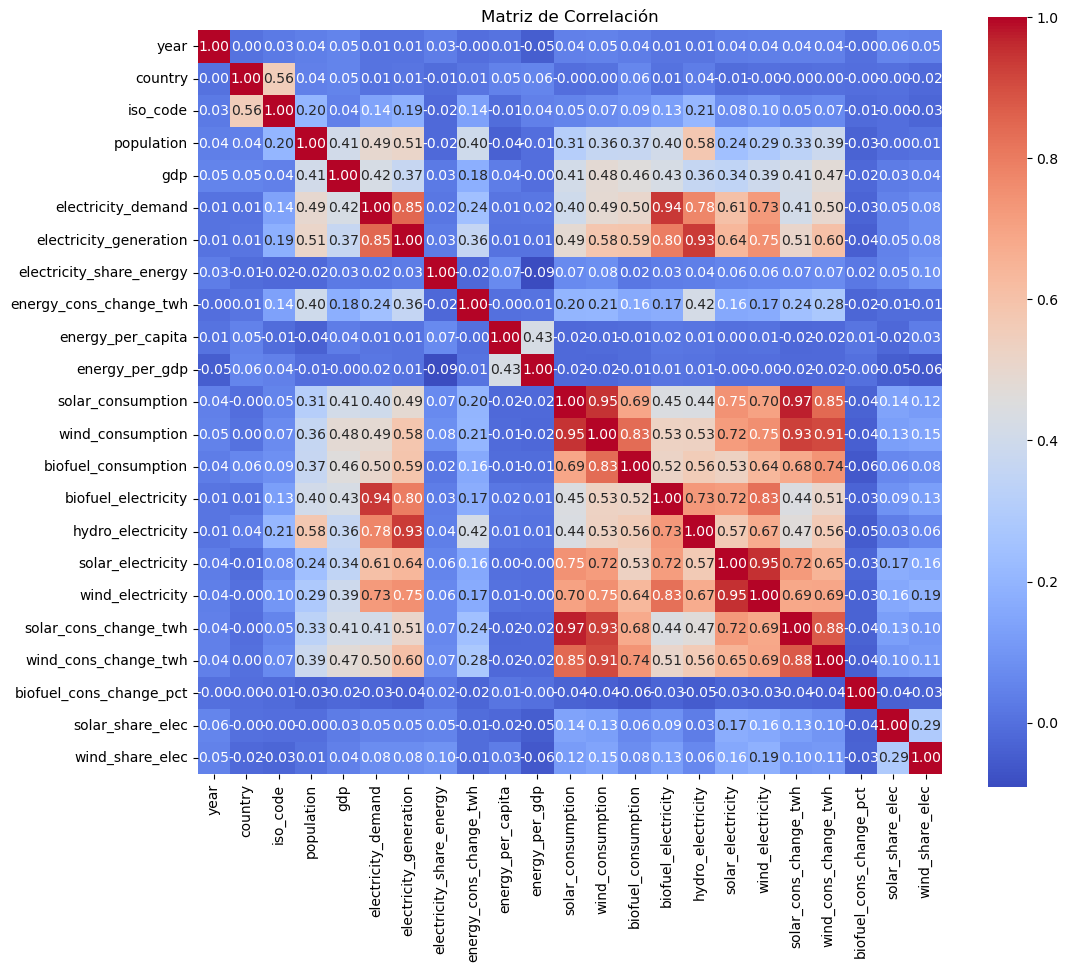

In [3]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

In [4]:
# 3. Separar características y variables objetivo
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
X = df.drop(columns=target_columns)
y = df[target_columns]

In [5]:
# 4. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# 5. Definir el modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))


In [7]:
# 6. Entrenar el modelo
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [8]:
# 7. Realizar predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# Mostrar las predicciones completas
print("Predicciones completas:")
print(y_pred)

Predicciones completas:
      solar_electricity  wind_electricity  hydro_electricity  \
0         -4.730000e-17          0.000000      -5.900000e-17   
1         -4.730000e-17          0.000000      -5.900000e-17   
2         -4.730000e-17          0.000000      -5.900000e-17   
3         -4.730000e-17          0.000000      -4.215808e-01   
4         -2.181491e-01         -0.273015      -4.721199e-01   
5         -2.181491e-01         -0.278477      -5.001555e-01   
6         -2.181491e-01         -0.278477      -4.971472e-01   
7         -4.730000e-17          0.000000      -5.900000e-17   
8         -4.730000e-17          0.000000      -5.900000e-17   
9         -2.181491e-01         -0.278477      -4.768767e-01   
10        -2.181491e-01         -0.278477      -4.354971e-01   
11        -4.730000e-17          0.000000      -5.900000e-17   
12        -4.730000e-17          0.000000      -5.900000e-17   
13        -2.168520e-01         -0.127087      -4.712427e-01   
14        -4.730

In [9]:
# 8. Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

MAE: 0.01, RMSE: 0.12, R²: 0.99


In [10]:
# 9. Ajustar el GridSearch para pruebas más rápidas
param_grid = {
    'estimator__n_estimators': [50, 100],  # Reducido para acelerar
    'estimator__max_depth': [None, 10],
    'estimator__min_samples_split': [2]
}

grid_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print(f"MAE (Mejor Modelo): {-grid_search.best_score_:.4f}")


Mejores parámetros: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
MAE (Mejor Modelo): 0.0147


In [11]:
# 10. Guardar el modelo
dump(grid_search, 'model/energy_model_seap_v2.joblib')

# Guardar los nombres de las características usadas durante el entrenamiento
features = X_train.columns.tolist()  # Obtener las columnas del conjunto de entrenamiento
dump(features, 'model/energy_model_features_v2.joblib')  # Guardar las características
# Guardar las columnas utilizadas para el modelo
features_filepath = 'model/energy_model_features_columns_v2.txt'
with open(features_filepath, 'w') as f:
    for column in X.columns:
        f.write(f"{column}\n")

logging.info("Modelo guardado.")

In [12]:
# 11. Validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE (Validación Cruzada): {-cv_scores.mean():.4f}")


MAE (Validación Cruzada): 0.0536


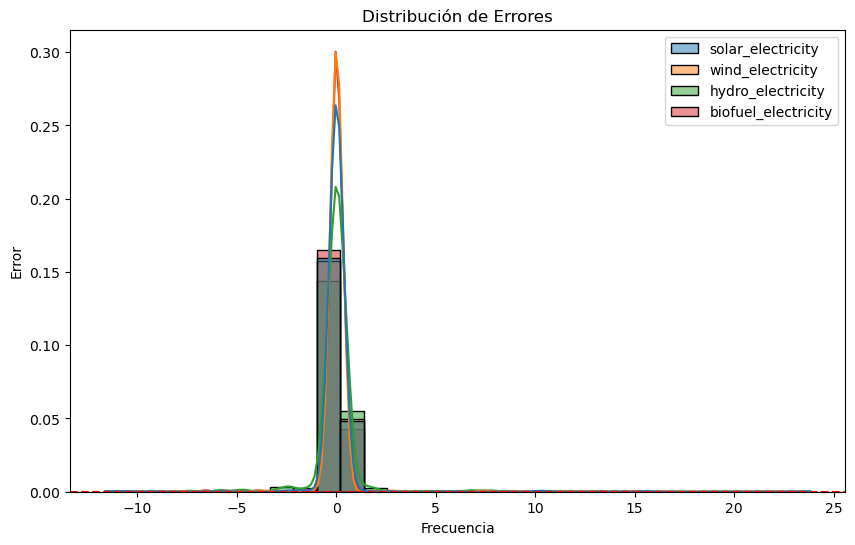

In [13]:
# 12. Analizar la distribución de errores

# Calcular los errores
errors = y_test - y_pred

# Crear la gráfica con errores en el eje Y
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, stat='density', color='blue')  # Agrega 'stat' para densidad
plt.title('Distribución de Errores')
plt.ylabel('Error')  # Cambiar el eje Y a "Error"
plt.xlabel('Frecuencia')  # Cambiar el eje X a "Frecuencia"
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para referencia
plt.show()


Top 10 características más importantes:
                        Importance
solar_consumption         0.346072
electricity_demand        0.171051
electricity_generation    0.167310
solar_share_elec          0.128890
solar_cons_change_twh     0.066386
year                      0.055822
wind_share_elec           0.024224
wind_cons_change_twh      0.010029
wind_consumption          0.009213
population                0.005941


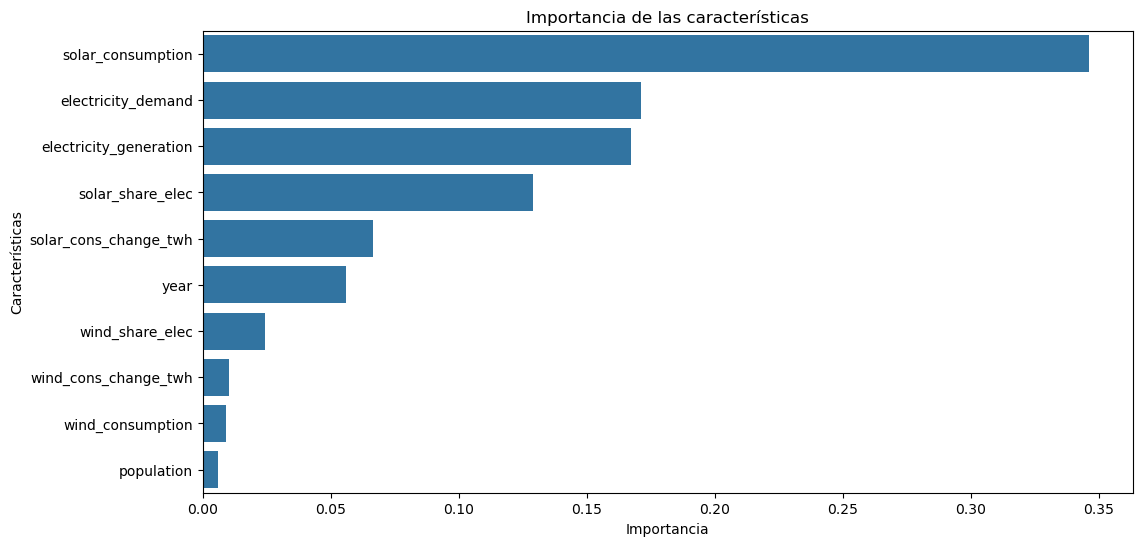

In [14]:
# 13. Importancia de las características
importances = model.estimators_[0].feature_importances_
feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes:")
print(feature_importances.head(10))

# Graficar la importancia de las características
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances["Importance"].head(10), y=feature_importances.index[:10])
plt.title("Importancia de las características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



In [15]:
# 14. Definir el modelo de red neuronal
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(target_columns), activation='linear')  # Salida para múltiples objetivos
])


In [16]:
# 15. Compilar el modelo
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [17]:
# 16. Entrenar el modelo
nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3966.0234 - mae: 23.9853 - val_loss: 0.7665 - val_mae: 0.2900
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7283 - mae: 0.3025 - val_loss: 0.5432 - val_mae: 0.2353
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5179 - mae: 0.2617 - val_loss: 0.4149 - val_mae: 0.1928
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3435 - mae: 0.2227 - val_loss: 0.3487 - val_mae: 0.1831
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3024 - mae: 0.2044 - val_loss: 0.3442 - val_mae: 0.2441
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3448 - mae: 0.2158 - val_loss: 0.3134 - val_mae: 0.2095
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2277 - mae: 0.1842 - val_loss: 0.3012 - val_mae: 0.2374
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2070 - mae: 0.1796 - val_loss: 0.4779 - val_mae: 0.4778
Epoch 9/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [18]:
# 17. Realizar predicciones con la red neuronal
y_pred_nn = nn_model.predict(X_test)

# Convertir las predicciones en un DataFrame
y_pred_nn = pd.DataFrame(y_pred_nn, columns=target_columns)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [19]:
# 18. Calcular métricas de rendimiento para el modelo de red neuronal
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"MAE (Red Neuronal): {mae_nn:.2f}, RMSE (Red Neuronal): {rmse_nn:.2f}, R² (Red Neuronal): {r2_nn:.2f}")


MAE (Red Neuronal): 0.24, RMSE (Red Neuronal): 0.43, R² (Red Neuronal): 0.82


In [20]:
# 19. Guardar el modelo de red neuronal
nn_model.save('model/energy_nn_model.h5')  # Guardar el modelo en formato HDF5

In [21]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Cargar los datos
cleaned_data = pd.read_csv('data/clean/cleaned_data.csv')
raw_data = pd.read_csv('data/raw/owid-energy-data.csv')

# Manejo de nulos en raw_data
# Rellenar los nulos solo en columnas numéricas
numeric_cols = raw_data.select_dtypes(include='number').columns
raw_data[numeric_cols] = raw_data[numeric_cols].fillna(raw_data[numeric_cols].mean())

# Asegúrate de que 'year' es del tipo correcto
raw_data['year'] = raw_data['year'].astype(int)

# Convertir 'country' a tipo string en ambos DataFrames
cleaned_data['country'] = cleaned_data['country'].astype(str)
raw_data['country'] = raw_data['country'].astype(str)

# Unir los DataFrames
merged_data = pd.merge(cleaned_data, raw_data, on=['country', 'year'], how='outer')

# Verificar el resultado
print(merged_data.info())
print(merged_data.head())

# Guardar el nuevo DataFrame
merged_data.to_csv('data/clean/merged_data.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43624 entries, 0 to 43623
Columns: 150 entries, year to wind_share_energy
dtypes: float64(147), int64(1), object(2)
memory usage: 49.9+ MB
None
   year       country  iso_code_x  population_x     gdp_x  \
0  1980  -0.010988888   -0.264713     -0.241177 -0.162299   
1  1981  -0.010988888   -0.264713     -0.241043 -0.162415   
2  1982  -0.010988888   -0.264713     -0.240908 -0.162364   
3  1983  -0.010988888   -0.264713     -0.240765 -0.162464   
4  1984  -0.010988888   -0.264713     -0.240613 -0.162482   

   electricity_demand_x  electricity_generation_x  electricity_share_energy_x  \
0                   0.0                       0.0               -2.360000e-15   
1                   0.0                       0.0               -2.360000e-15   
2                   0.0                       0.0               -2.360000e-15   
3                   0.0                       0.0               -2.360000e-15   
4                   0.0           

In [22]:


# 1. Verificar cuántos valores nulos hay en cada columna
print("Valores nulos antes de la imputación:")
print(merged_data.isnull().sum())

# 2. Imputación de valores nulos

# Rellenar valores nulos en columnas numéricas con la media
numerical_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)

# Rellenar valores nulos en columnas categóricas con la moda
categorical_cols = merged_data.select_dtypes(include=['object']).columns

for col in categorical_cols:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

# 3. Renombrar columnas que terminan en '_x'
merged_data.rename(columns=lambda x: x[:-2] if x.endswith('_x') else x, inplace=True)

# 4. Verificar nuevamente los valores nulos
print("Valores nulos después de la imputación:")
print(merged_data.isnull().sum())

# 5. Opcional: Guardar el DataFrame limpio y renombrado en un archivo CSV
merged_data.to_csv('data/clean/cleaned_merged_data.csv', index=False)

# 6. Verificar los nombres de las columnas
print(merged_data.columns)



Valores nulos antes de la imputación:
year                                                0
country                                             0
iso_code_x                                      21812
population_x                                    21812
gdp_x                                           21812
electricity_demand_x                            21812
electricity_generation_x                        21812
electricity_share_energy_x                      21812
energy_cons_change_twh_x                        21812
energy_per_capita_x                             21812
energy_per_gdp_x                                21812
solar_consumption_x                             21812
wind_consumption_x                              21812
biofuel_consumption_x                           21812
biofuel_electricity_x                           21812
hydro_electricity_x                             21812
solar_electricity_x                             21812
wind_electricity_x                          

In [23]:

# Verificar el nuevo DataFrame después de la limpieza

cleaned_merged_data = pd.read_csv('data/clean/cleaned_merged_data.csv')

cleaned_merged_data.head(10)

,year,country,iso_code,population,gdp,electricity_demand,electricity_generation,electricity_share_energy,energy_cons_change_twh,energy_per_capita,energy_per_gdp,solar_consumption,wind_consumption,biofuel_consumption,biofuel_electricity,hydro_electricity,solar_electricity,wind_electricity,solar_cons_change_twh,wind_cons_change_twh,biofuel_cons_change_pct,solar_share_elec,wind_share_elec,iso_code_y,population_y,gdp_y,biofuel_cons_change_pct_y,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption_y,biofuel_elec_per_capita,biofuel_electricity_y,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand_y,electricity_generation_y,electricity_share_energy_y,energy_cons_change_pct,energy_cons_change_twh_y,energy_per_capita_y,energy_per_gdp_y,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity_y,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh_y,solar_consumption_y,solar_elec_per_capita,solar_electricity_y,solar_energy_per_capita,solar_share_elec_y,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh_y,wind_consumption_y,wind_elec_per_capita,wind_electricity_y,wind_energy_per_capita,wind_share_elec_y,wind_share_energy
0,1980,-0.010989,-0.264713,-0.241177,-0.162299,0.0,0.0,-2.360000e-15,-3.990000e-17,-0.832561,-0.561411,4.360000e-17,4.930000e-17,0.0,0.0,-5.900000e-17,-4.730000e-17,0.0,-5.420000e-17,4.790000e-17,9.280000e-17,7.750000e-17,8.250000e-17,AGO,1.054051e+08,4.260596e+11,45.489759,2.867027,136.600523,39.082519,66.75087,11.262839,1.865575,0.426809,480.69053,23.972574,31.855349,6248.340483,1897.537265,717.308362,326.441713,18.857943,17.000357,3463.255628,984.531283,17.340562,20.497083,612.426238,780.497711,16.105343,4.010613,87.598498,25877.5446,1.782259,2.331504,117.645595,2468.366007,547.013599,30753.122689,6449.881201,65.453062,85.09336,19.099318,38.615529,1495.377442,894.779013,178.691183,10948.535533,1.199436e+14,17.594405,6538.234728,623.861623,19.538966,20.466251,310.986405,5.668136,8.8482

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

# Suponiendo que 'cleaned_merged_data' es tu DataFrame limpio.

# Identificar columnas categóricas
categorical_cols = cleaned_merged_data.select_dtypes(include=['object']).columns

# Usar Label Encoding para cada columna categórica
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    cleaned_merged_data[col] = le.fit_transform(cleaned_merged_data[col])
    label_encoders[col] = le  # Guardar el encoder para futuras referencias

# Definir las características (X) y las variables objetivo (y)
X = cleaned_merged_data.drop(columns=['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity'])  # Eliminar variables objetivo
y = cleaned_merged_data[['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']]  # Variables objetivo

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo secuencial
model = Sequential()

# Añadir capas densas con Batch Normalization y Dropout
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Normalización
model.add(Dropout(0.2))  # Reducido Dropout

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Normalización
model.add(Dropout(0.2))  # Reducido Dropout

# Capa de salida: múltiples neuronas para predecir múltiples variables
model.add(Dense(y_train.shape[1]))  # Cambiado para ajustarse a múltiples salidas

# Compilar el modelo con una tasa de aprendizaje más baja
optimizer = Adam(learning_rate=0.0005)  # Tasa de aprendizaje ajustada
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping ajustado
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)



TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['float', 'str']

In [ ]:
# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,  # Tamaño de batch aumentado
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluar el rendimiento
mae, rmse = model.evaluate(X_test, y_test, verbose=0)[1], model.evaluate(X_test, y_test, verbose=0)[0] ** 0.5
print(f"MAE (Red Neuronal): {mae:.2f}, RMSE (Red Neuronal): {rmse:.2f}")

# Guardar el mejor modelo
model.save('model/final_model.keras')

In [ ]:
import numpy as np

# Evaluar el rendimiento
mae = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

print(f"MAE (Red Neuronal): {mae:.2f}")
print(f"RMSE (Red Neuronal): {rmse:.2f}")

In [ ]:
# Graficar pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida (train)')
plt.plot(history.history['val_loss'], label='Pérdida (val)')
plt.title('Curvas de Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
# Comparar predicciones con valores reales
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test['solar_electricity'], y=y_pred[:, 0], label='Solar Electricity', alpha=0.6)
sns.scatterplot(x=y_test['wind_electricity'], y=y_pred[:, 1], label='Wind Electricity', alpha=0.6)
sns.scatterplot(x=y_test['hydro_electricity'], y=y_pred[:, 2], label='Hydro Electricity', alpha=0.6)
sns.scatterplot(x=y_test['biofuel_electricity'], y=y_pred[:, 3], label='Biofuel Electricity', alpha=0.6)

plt.plot([y_test.min().min(), y_test.max().max()], [y_test.min().min(), y_test.max().max()], color='red', ls='--')  # Línea de referencia
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()


In [ ]:
# Calcular errores
errors = y_pred - y_test

# Graficar histograma de errores
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.title('Histograma de Errores')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='red', linestyle='--')  # Línea para mostrar el valor cero
plt.show()


In [ ]:
# Desviación estándar de MAE y RMSE
mae_std = np.std(history.history['mae'])
rmse_std = np.std(np.sqrt(history.history['val_loss']))  # Usando val_loss para RMSE

print(f"Desviación estándar MAE: {mae_std:.2f}")
print(f"Desviación estándar RMSE: {rmse_std:.2f}")


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Calcular Mediana del Error Absoluto
mae_median = np.median(np.abs(errors))

print(f"R²: {r2:.2f}")
print(f"Mediana del Error Absoluto: {mae_median:.2f}")

In [ ]:
import matplotlib.pyplot as plt

# Graficar las predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Línea de identidad
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que 'cleaned_merged_data' es tu DataFrame limpio
# Asegúrate de que cleaned_merged_data contiene solo las columnas necesarias
# Definir las columnas de interés
columns_of_interest = ['year', 'country', 'iso_code', 'population', 'gdp', 
                        'electricity_demand', 'electricity_generation', 
                        'electricity_share_energy', 'energy_cons_change_twh', 
                        'energy_per_capita', 'energy_per_gdp', 
                        'solar_consumption', 'wind_consumption', 
                        'biofuel_consumption', 'biofuel_electricity', 
                        'hydro_electricity', 'solar_electricity', 
                        'wind_electricity', 'solar_cons_change_twh', 
                        'wind_cons_change_twh', 'biofuel_cons_change_pct', 
                        'solar_share_elec', 'wind_share_elec',
                        'solar_electricity', 'wind_electricity', 
                        'hydro_electricity', 'biofuel_electricity']  # variables objetivo

# Filtrar el DataFrame
filtered_data = cleaned_merged_data[columns_of_interest]

# Calcular la matriz de correlación
correlation_matrix = filtered_data.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 10))

# Generar un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, 
            linewidths=.5, linecolor='gray')

# Añadir título
plt.title('Matriz de Correlación de Variables')

# Mostrar el gráfico
plt.show()



In [ ]:
selected_features = [
    'year', 
    'population', 
    'gdp', 
    'electricity_demand', 
    'electricity_generation', 
    'energy_per_capita', 
    'energy_per_gdp', 
    'greenhouse_gas_emissions', 
    'renewables_share_energy', 
    'carbon_intensity_elec', 
    'nuclear_electricity', 
    'fossil_share_energy'
]

# Filtrar el DataFrame
filtered_data = cleaned_merged_data[selected_features]

# Calcular la matriz de correlación
correlation_matrix = filtered_data.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 10))

# Generar un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, 
            linewidths=.5, linecolor='gray')

# Añadir título
plt.title('Matriz de Correlación de Variables')

# Mostrar el gráfico
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

# Suponiendo que 'cleaned_merged_data' es tu DataFrame limpio.

# Identificar columnas categóricas
categorical_cols = cleaned_merged_data.select_dtypes(include=['object']).columns

# Usar Label Encoding para cada columna categórica
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    cleaned_merged_data[col] = le.fit_transform(cleaned_merged_data[col])
    label_encoders[col] = le  # Guardar el encoder para futuras referencias

# Definir las características seleccionadas (X) y las variables objetivo (y)
selected_features = [
    'year', 
    'population', 
    'gdp', 
    'electricity_demand', 
    'electricity_generation', 
    'energy_per_capita', 
    'energy_per_gdp', 
    'greenhouse_gas_emissions', 
    'renewables_share_energy', 
    'carbon_intensity_elec', 
    'nuclear_electricity', 
    'fossil_share_energy'
]

X = cleaned_merged_data[selected_features]  # Seleccionar solo las características seleccionadas
y = cleaned_merged_data[['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']]  # Variables objetivo

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo secuencial
model = Sequential()

# Añadir capas densas con Batch Normalization y Dropout
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Normalización
model.add(Dropout(0.2))  # Reducido Dropout

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Normalización
model.add(Dropout(0.2))  # Reducido Dropout

# Capa de salida: múltiples neuronas para predecir múltiples variables
model.add(Dense(y_train.shape[1]))  # Cambiado para ajustarse a múltiples salidas

# Compilar el modelo con una tasa de aprendizaje más baja
optimizer = Adam(learning_rate=0.0005)  # Tasa de aprendizaje ajustada
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping ajustado
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping, checkpoint],
                    verbose=1)  # Puedes ajustar 'verbose' según tus necesidades


In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Comparar predicciones con valores reales
predictions_df = pd.DataFrame({
    'Actual Solar Electricity': y_test['solar_electricity'],
    'Predicted Solar Electricity': y_pred[:, 0],  # Ajusta el índice según la variable
    'Actual Wind Electricity': y_test['wind_electricity'],
    'Predicted Wind Electricity': y_pred[:, 1],
    'Actual Hydro Electricity': y_test['hydro_electricity'],
    'Predicted Hydro Electricity': y_pred[:, 2],
    'Actual Biofuel Electricity': y_test['biofuel_electricity'],
    'Predicted Biofuel Electricity': y_pred[:, 3]
})

print(predictions_df.head())  # Muestra las primeras filas de las predicciones


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular MAE, RMSE y R²
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')


In [ ]:
import matplotlib.pyplot as plt

# Graficar comparaciones de predicciones vs reales
plt.figure(figsize=(14, 6))

# Solar Electricity
plt.subplot(1, 4, 1)
plt.scatter(y_test['solar_electricity'], y_pred[:, 0], alpha=0.5)
plt.xlabel('Actual Solar Electricity')
plt.ylabel('Predicted Solar Electricity')
plt.title('Predicted vs Actual Solar Electricity')
plt.plot([y_test['solar_electricity'].min(), y_test['solar_electricity'].max()], 
         [y_test['solar_electricity'].min(), y_test['solar_electricity'].max()], color='red')  # Línea de referencia

# Wind Electricity
plt.subplot(1, 4, 2)
plt.scatter(y_test['wind_electricity'], y_pred[:, 1], alpha=0.5)
plt.xlabel('Actual Wind Electricity')
plt.ylabel('Predicted Wind Electricity')
plt.title('Predicted vs Actual Wind Electricity')
plt.plot([y_test['wind_electricity'].min(), y_test['wind_electricity'].max()], 
         [y_test['wind_electricity'].min(), y_test['wind_electricity'].max()], color='red')

# Hydro Electricity
plt.subplot(1, 4, 3)
plt.scatter(y_test['hydro_electricity'], y_pred[:, 2], alpha=0.5)
plt.xlabel('Actual Hydro Electricity')
plt.ylabel('Predicted Hydro Electricity')
plt.title('Predicted vs Actual Hydro Electricity')
plt.plot([y_test['hydro_electricity'].min(), y_test['hydro_electricity'].max()], 
         [y_test['hydro_electricity'].min(), y_test['hydro_electricity'].max()], color='red')

# Biofuel Electricity
plt.subplot(1, 4, 4)
plt.scatter(y_test['biofuel_electricity'], y_pred[:, 3], alpha=0.5)
plt.xlabel('Actual Biofuel Electricity')
plt.ylabel('Predicted Biofuel Electricity')
plt.title('Predicted vs Actual Biofuel Electricity')
plt.plot([y_test['biofuel_electricity'].min(), y_test['biofuel_electricity'].max()], 
         [y_test['biofuel_electricity'].min(), y_test['biofuel_electricity'].max()], color='red')

plt.tight_layout()
plt.show()


In [ ]:
import shap

# Crear un objeto explainer de SHAP
explainer = shap.KernelExplainer(model.predict, X_train)

# Calcular valores SHAP
shap_values = explainer.shap_values(X_test)

# Visualizar valores SHAP
shap.summary_plot(shap_values, X_test, feature_names=selected_features)


Test

In [ ]:
from keras.regularizers import l2
from keras.optimizers import Adam

# Crear el modelo secuencial
model = Sequential()

# Añadir capas densas con Batch Normalization y Dropout
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Normalización
model.add(Dropout(0.2))  # Reducido Dropout

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Normalización
model.add(Dropout(0.2))  # Reducido Dropout

# Capa de salida
model.add(Dense(y_train.shape[1]))  # Sin activación (regresión)

# Compilar el modelo con una tasa de aprendizaje más baja
optimizer = Adam(learning_rate=0.0005)  # Tasa de aprendizaje ajustada
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping ajustado
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,  # Tamaño de batch aumentado
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluar el rendimiento
mae, rmse = model.evaluate(X_test, y_test, verbose=0)[1], model.evaluate(X_test, y_test, verbose=0)[0] ** 0.5
print(f"MAE (Red Neuronal): {mae:.2f}, RMSE (Red Neuronal): {rmse:.2f}")


# Guardar el mejor modelo
model.save('model/final_model.keras')



In [ ]:
# 20. Tendencias de energía a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='solar_electricity', label='Solar Electricity')
sns.lineplot(data=df, x='year', y='wind_electricity', label='Wind Electricity')
sns.lineplot(data=df, x='year', y='hydro_electricity', label='hydro electricity')
sns.lineplot(data=df, x='year', y='biofuel_electricity', label='biofuel Electricity')
plt.title('Tendencias de Energía a lo Largo del Tiempo')
plt.xlabel('Año')
plt.ylabel('Electricidad')
plt.legend()
plt.show()


In [ ]:
# 21. Estadísticas descriptivas

columns_of_interest = [
    'year', 'country', 'iso_code', 'population', 'gdp', 
    'electricity_demand', 'electricity_generation', 'electricity_share_energy',
    'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp', 
    'solar_consumption', 'wind_consumption', 'biofuel_consumption', 
    'solar_cons_change_twh', 'wind_cons_change_twh', 
    'biofuel_cons_change_pct', 'solar_share_elec', 'wind_share_elec'
]

# Filtrar el DataFrame
filtered_data = df[columns_of_interest]

# Obtener estadísticas descriptivas
statistics = filtered_data.describe()

# Mostrar las estadísticas
display(statistics)

In [ ]:
# 22. Diversas visualizaciones

# Establecer el estilo de seaborn
sns.set(style='whitegrid')

# 1. Gráfico de Barras de la Demanda y Generación de Electricidad por Año
filtered_data = data[['year', 'electricity_demand', 'electricity_generation']]
yearly_data = filtered_data.groupby('year').sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_data, x='year', y='electricity_demand', label='Electricity Demand', marker='o')
sns.lineplot(data=yearly_data, x='year', y='electricity_generation', label='Electricity Generation', marker='o')
plt.title('Electricity Demand and Generation Over Years')
plt.xlabel('Year')
plt.ylabel('Total (in TWh)')
plt.legend()
plt.grid()
plt.show()


# 3. Gráfico de Barras de Consumo de Energía por Tipo para el año 2021
specific_year_data = data[data['year'] == 2021]
energy_sources = ['solar_consumption', 'wind_consumption', 'biofuel_consumption', 'hydro_electricity']
consumption_data = specific_year_data[energy_sources].sum().reset_index()
consumption_data.columns = ['Energy Source', 'Total Consumption (TWh)']

plt.figure(figsize=(12, 6))
sns.barplot(data=consumption_data, x='Energy Source', y='Total Consumption (TWh)', palette='viridis')
plt.title('Energy Consumption by Source in 2021')
plt.xlabel('Energy Source')
plt.ylabel('Total Consumption (in TWh)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 4. Gráfico de Caja de Consumo de Energía por Fuente
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[energy_sources])
plt.title('Distribution of Energy Consumption by Source')
plt.xlabel('Energy Source')
plt.ylabel('Consumption (in TWh)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 1. Gráfico de Línea de Población y PIB a lo Largo de los Años
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='year', y='population', label='Population', color='blue', marker='o')
sns.lineplot(data=data, x='year', y='gdp', label='GDP', color='orange', marker='o')
plt.title('Population and GDP Over Years')
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import folium
import geopandas as gpd

In [ ]:
#23. Cargar el archivo Shapefile
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Mostrar el DataFrame entero
display(world)

In [ ]:
# 24. Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Agrupar y preparar los datos para el mapa
data_map = data[['country', 'iso_code', 'electricity_demand']].groupby('country').mean().reset_index()

# Convertir la columna 'country' a string
data_map['country'] = data_map['country'].astype(str)

# Cargar el archivo Shapefile de Natural Earth (asegúrate de que apunte a la ruta correcta)
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'NAME'
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Rellenar los valores NaN en 'electricity_demand' con 0 (o lo que consideres apropiado)
world['electricity_demand'].fillna(0, inplace=True)

# Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Crear un GeoDataFrame con las geometrías y datos de los países para usar con Folium
geo_data = world[['geometry', 'NAME', 'electricity_demand']].dropna()

# Convertir el GeoDataFrame a JSON para que Folium pueda interpretarlo
geo_json = geo_data.to_json()

# Añadir la capa de coropletas (choropleth) al mapa
folium.Choropleth(
    geo_data=geo_json,
    data=world,  # Data para el mapa
    columns=['NAME', 'electricity_demand'],  # Columnas usadas para el shading
    key_on='feature.properties.NAME',  # Vinculación entre el JSON y los datos
    fill_color='OrRd',  # Esquema de color
    fill_opacity=0.7,  # Opacidad de los colores
    line_opacity=0.2,
    legend_name='Demanda Eléctrica por País'
).add_to(m)

# Mostrar el mapa
m.save("mapa_demanda_electrica.html")
m




In [ ]:
# 25. Crear un mapa de calor de correlación

# Establece la figura
plt.figure(figsize=(12, 8))

# Crea el scatterplot
sns.scatterplot(
    data=df, 
    x='iso_code', 
    y='country', 
    hue='electricity_demand',  # Cambia 'country' por 'electricity_demand'
    palette='viridis',  # Cambia la paleta si es necesario
    size='electricity_demand',  # Opcional: usa tamaño basado en 'electricity_demand'
    sizes=(20, 200),  # Ajusta los tamaños de los puntos
    legend=None
)

# Añade etiquetas y título
plt.xlabel('ISO Code')
plt.ylabel('Country')
plt.title('Electricity Demand by Country and ISO Code')
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que 'corr_matrix' es tu matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Electricity Demand')
plt.show()


In [ ]:
# 26. Crear un mapa de calor de correlación

# Calcula la matriz de correlación
corr_matrix = df.corr()

# Imprime la matriz de correlación
print("Correlation Matrix:")
print(corr_matrix)

# Si deseas imprimir solo un conjunto específico de correlaciones, por ejemplo, con respecto a 'electricity_demand'
print("\nCorrelations with Electricity Demand:")
print(corr_matrix['electricity_demand'].sort_values(ascending=False))


In [ ]:
# Agrupar y preparar los datos para el mapa
data_map = data[['country', 'iso_code', 'electricity_demand']].groupby('country').mean().reset_index()

# Imprimir el DataFrame agrupado
print("Data Map (Agrupado):")
print(data_map)

# Comprobar los datos originales
print("Datos Originales:")
print(data[['country', 'electricity_demand']].head())  # Muestra las primeras filas de interés

# Convertir la columna 'country' a string
data_map['country'] = data_map['country'].astype(str)

# Cargar el archivo Shapefile de Natural Earth
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'NAME'
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Comprobar el resultado del merge
print("Resultado del Merge:")
print(world[['NAME', 'electricity_demand']].head())

# Rellenar los valores NaN en 'electricity_demand' con 0
world['electricity_demand'].fillna(0, inplace=True)

# Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Crear un GeoDataFrame con las geometrías y datos de los países para usar con Folium
geo_data = world[['geometry', 'NAME', 'electricity_demand']].dropna()

# Convertir el GeoDataFrame a JSON para que Folium pueda interpretarlo
geo_json = geo_data.to_json()

# Añadir la capa de coropletas (choropleth) al mapa
folium.Choropleth(
    geo_data=geo_json,
    data=world,  # Data para el mapa
    columns=['NAME', 'electricity_demand'],  # Columnas usadas para el shading
    key_on='feature.properties.NAME',  # Vinculación entre el JSON y los datos
    fill_color='YlGn',  # Esquema de color
    fill_opacity=0.7,  # Opacidad de los colores
    line_opacity=0.2,
    legend_name='Demanda Eléctrica por País'
).add_to(m)

# Añadir marcadores para destacar los países con la mayor demanda
for _, row in world.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"{row['NAME']}: {row['electricity_demand']:.2f}",
        icon=None
    ).add_to(m)

# Mostrar el mapa
m.save("mapa_demanda_electrica.html")
m


In [ ]:
# Limpiar y normalizar los nombres de países en el DataFrame
data_map['country'] = data_map['country'].str.strip()  # Eliminar espacios en blanco
data_map['country'] = data_map['country'].str.title()  # Capitalizar correctamente los nombres

# Limpiar los nombres de los países en el shapefile
world['NAME'] = world['NAME'].str.strip()  # Eliminar espacios en blanco
world['NAME'] = world['NAME'].str.title()  # Capitalizar correctamente los nombres

# Verificar algunos nombres para asegurarte de que coinciden
print("Nombres de países en data_map:")
print(data_map['country'].unique())

print("Nombres de países en world:")
print(world['NAME'].unique())


In [ ]:
# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'NAME'
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Comprobar el resultado del merge nuevamente
print("Resultado del Merge después de normalizar:")
print(world[['NAME', 'electricity_demand']].head())


In [ ]:
# Hacer merge de los datos de electricidad con el mapa mundial
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Verificar las columnas en el DataFrame world después del merge
print("Columnas en el DataFrame 'world' después del merge:")
print(world.columns)

# Comprobar los primeros registros para asegurarnos de que electricity_demand se ha añadido
print("Primeros registros del DataFrame 'world' después del merge:")
print(world.head())

In [ ]:
import pandas as pd

# Supongamos que 'world' es el DataFrame después del merge
# Verifica las columnas que están duplicadas
print(world.columns)

# Eliminar columnas duplicadas
# Puedes decidir qué columnas mantener. Aquí, solo se conserva '_x'
world_cleaned = world.loc[:, ~world.columns.str.endswith('_y')]

# Si necesitas renombrar las columnas para que queden claras
world_cleaned.rename(columns=lambda x: x.rstrip('_x'), inplace=True)

# Verifica el nuevo DataFrame
print(world_cleaned.head())


In [ ]:
print(world_cleaned.columns)

print(world_cleaned.info())

print(world_cleaned.head())


In [ ]:
import pandas as pd
import geopandas as gpd
import folium

# Cargar los datos limpiados
cleaned_data = pd.read_csv('data/clean/cleaned_data_2.csv')

# Verificar los tipos de datos
print("Tipos de datos en cleaned_data:")
print(cleaned_data.dtypes)

# Step 1: Check unique values in the electricity_demand column
print(cleaned_data['electricity_demand'].unique())

# Step 2: Clean the electricity_demand column
cleaned_data['electricity_demand'] = pd.to_numeric(cleaned_data['electricity_demand'], errors='coerce')

# Optional: Check for any NaN values after conversion
print(cleaned_data['electricity_demand'].isnull().sum())

# Step 3: Group and prepare the data for the map
data_map = cleaned_data[['country', 'iso_code', 'electricity_demand']].groupby('iso_code').mean().reset_index()

# Step 4: Print the DataFrame grouped
print("Data Map (Grouped):")
print(data_map)

# Comprobar los datos originales
print("Datos Originales:")
print(cleaned_data[['country', 'electricity_demand']].head())  # Muestra las primeras filas de interés

# Cargar el archivo Shapefile de Natural Earth
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Normalizar la columna 'ISO_A2' en el shapefile (la columna de código ISO)
world['ISO_A2'] = world['ISO_A2'].astype(str).str.strip().str.lower()

# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'ISO_A2'
world = world.merge(data_map, left_on='ISO_A2', right_on='iso_code', how='left')

# Comprobar el resultado del merge
print("Resultado del Merge:")
print(world[['ISO_A2', 'electricity_demand']].head())

# Rellenar los valores NaN en 'electricity_demand' con 0
world['electricity_demand'].fillna(0, inplace=True)

# Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Crear un GeoDataFrame con las geometrías y datos de los países para usar con Folium
geo_data = world[['geometry', 'ISO_A2', 'electricity_demand']].dropna()

# Convertir el GeoDataFrame a JSON para que Folium pueda interpretarlo
geo_json = geo_data.to_json()

# Añadir la capa de coropletas (choropleth) al mapa
folium.Choropleth(
    geo_data=geo_json,
    data=world,  # Data para el mapa
    columns=['ISO_A2', 'electricity_demand'],  # Columnas usadas para el shading
    key_on='feature.properties.ISO_A2',  # Vinculación entre el JSON y los datos
    fill_color='YlGn',  # Esquema de color
    fill_opacity=0.7,  # Opacidad de los colores
    line_opacity=0.2,
    legend_name='Demanda Eléctrica por País'
).add_to(m)

# Añadir marcadores para destacar los países con la mayor demanda
for _, row in world.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"{row['NAME']}: {row['electricity_demand']:.2f}",
        icon=None
    ).add_to(m)

# Mostrar el mapa
m.save("mapa_demanda_electrica.html")

m


In [ ]:
# Check data types
print(world['ISO_A2'].dtype)  # Expect 'object'
print(data_map['iso_code'].dtype)  # Expect 'float64' or another type

# Convert 'iso_code' to string
data_map['iso_code'] = data_map['iso_code'].astype(str).str.strip().str.lower()

# Now perform the merge
world = world.merge(data_map, left_on='ISO_A2', right_on='iso_code', how='left')

# Check the result of the merge
print("Resultado del Merge:")
print(world.head())

Código original sin gráficos

In [ ]:
import geopandas as gpd

# Cargar el archivo Shapefile de Natural Earth
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Mostrar las columnas disponibles en el GeoDataFrame
print("Columnas en el GeoDataFrame world:")
world